<a href="https://colab.research.google.com/github/seovalue/deep-learning-paper-study/blob/master/self_laboratory/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이 notebook은 고려대학교 최윤제 연구원의 [튜토리얼](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py)을 참고하여 작성하였습니다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


In [2]:
standardizator = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,),(0.5,))])
train_data = dsets.MNIST(root='data/',train=True, transform=standardizator,download = True)
test_data = dsets.MNIST(root='data/',train=False,transform=standardizator,download=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
batch_size = 200
#train_data와 test_data를 200장 단위로 묶어서 넘겨준다.
train_data_loader = torch.utils.data.DataLoader(train_data,batch_size,shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data,batch_size,shuffle=True)

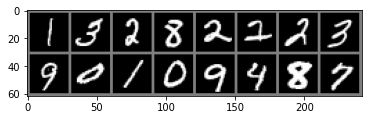

In [4]:
import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img): 
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
imshow_grid(example_mini_batch_img[0:16,:,:])

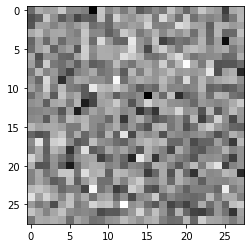

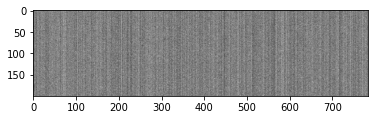

In [5]:
# Generator 구현하기

d_noise = 100
d_hidden = 256

def sample_z(batch_size = 1, d_noise = 100):
  return torch.randn(batch_size, d_noise, device = device)

G = nn.Sequential(
    nn.Linear(d_noise,d_hidden),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(d_hidden,d_hidden),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(d_hidden,28*28),
    nn.Tanh()
).to(device)

#노이즈 생성하기
z = sample_z()
#가짜 이미지 생성하기
img_fake = G(z).view(-1,28,28)
#이미지 출력하기
imshow(img_fake.squeeze().cpu().detach())

#Batch size 만큼 노이즈 생성하여 그리드로 출력하기
z = sample_z(batch_size)
img_fake = G(z)
imshow_grid(img_fake)

In [6]:
D = nn.Sequential(
    nn.Linear(28*28, d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,1),
    nn.Sigmoid()
).to(device)

print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)[:5]).transpose(0,1))

torch.Size([200, 784])
torch.Size([200, 1])
tensor([[0.4847, 0.4852, 0.4837, 0.4876, 0.4831]], device='cuda:0',
       grad_fn=<TransposeBackward0>)


In [7]:
criterion = nn.BCELoss()

def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):
    
    generator.train()
    discriminator.train()

    for img_batch, label_batch in train_data_loader:
        
        img_batch, label_batch = img_batch.to(device), label_batch.to(device)
        _optimizer_d.zero_grad()
        p_real = discriminator(img_batch.view(-1,28*28))
        p_fake = discriminator(generator(sample_z(batch_size,d_noise)))

        loss_d = criterion(p_real, torch.ones_like(p_real).to(device)) + \
        criterion(p_fake, torch.zeros_like(p_real).to(device))

        loss_d.backward()
        _optimizer_d.step()

        _optimizer_g.zero_grad()
        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))
        loss_g = -1 * torch.log(p_fake).mean()
        loss_g.backward()

        _optimizer_g.step()

In [8]:
def evaluate_model(generator,discriminator):
  
  p_real, p_fake = 0., 0.
  generator.eval()
  discriminator.eval()

  for img_batch, label_batch in test_data_loader:
    img_batch, label_batch = img_batch.to(device), label_batch.to(device)

    with torch.autograd.no_grad():
      p_real += (torch.sum(discriminator(img_batch.view(-1, 28*28))).item())/10000.
      p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item())/10000.

  return p_real, p_fake

(epoch 50/200) p_real: 0.606373, p_g: 0.217145


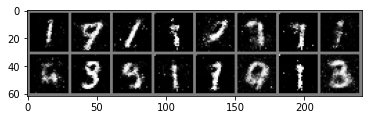

(epoch 100/200) p_real: 0.599528, p_g: 0.369886


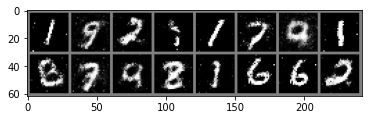

(epoch 150/200) p_real: 0.550766, p_g: 0.408942


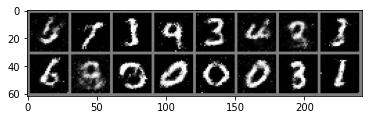

(epoch 200/200) p_real: 0.512581, p_g: 0.395758


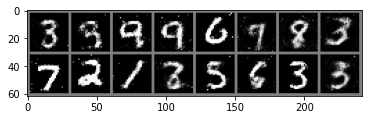

In [9]:
def init_params(model):
  for p in model.parameters():
    if(p.dim() > 1):
      nn.init.xavier_normal_(p)
    else:
      nn.init.uniform_(p,0.1,0.2)

init_params(G)
init_params(D)

optimizer_g = optim.Adam(G.parameters(), lr = 0.0002)
optimizer_d = optim.Adam(D.parameters(), lr=0.0002)

p_real_trace = []
p_fake_trace = []

for epoch in range(200):

  run_epoch(G,D, optimizer_g, optimizer_d)
  p_real, p_fake = evaluate_model(G,D)

  p_real_trace.append(p_real)
  p_fake_trace.append(p_fake)

  if((epoch+1)%50 == 0):
    print('(epoch %i/200) p_real: %f, p_g: %f' %(epoch+1, p_real, p_fake))
    imshow_grid(G(sample_z(16)).view(-1,1,28,28))

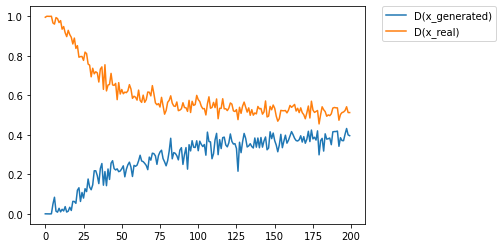

In [10]:
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

'Real Image'

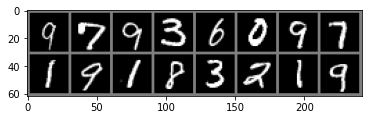

'Image that generated by GAN'

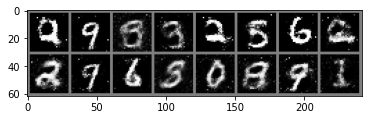

In [11]:
vis_loader = torch.utils.data.DataLoader(test_data, 16, True)
img_vis, label_vis   = next(iter(vis_loader))
display("Real Image")
imshow_grid(img_vis)

display("Image that generated by GAN")
imshow_grid(G(sample_z(16,100)).view(-1, 1, 28, 28))